In [ ]:
%matplotlib ipympl

# Ecohydrology

Building on the previous demos around integrated hydrology, we next consider temperate ecohydrology.  Here, by temperate we really mean that frozen soil is not a consideration, and by ecohydrology we mean that one wishes to represent evapotranspiration as a significant sink. 

Evapotranspiration is typically split into two components:

* potential evapotranspiration is governed by meteorological forcing (air temperature, relative humidity/vapor pressure, wind speed, etc) and describes the **potential** for the atmosphere to uptake water
* downregulation is the process of reducing potential evaporation due to limitations in soil or plant water availability

Given those definitions, we first describe methods for downregulation:
* evaporation downregulation due to soil resistance
* transpiration downregulation and distribution via empirical curves
* transpiration downregulation and distribution via relative permeability and plant water potential

Then we show a few different options for how to represent **potential evapotranspiration**, including:

* **prescribed P - ET** which assumes that ET is known from data or another model
* **Priestley-Taylor ET**: a simple model for total ET
* **Priestley-Taylor ET decomposed into four buckets**: a more complex variant of Priestley-Taylor is to split ET into four buckets -- canopy-water evaporation (of e.g. intercepted rainfall), bare ground evaporation, canopy transpiration, and snow sublimation.
* **full_energy** a full energy equation
* **simple_energy** a simplified energy equation

Lastly, we look at a more realistic problem with spatially variable evapotranspiration and lateral flow.

Throughout this worksheet, we will also demonstrate mass conservation and a mass balance calculation.  This is a crucial tool for all users to understand.

Author: Ethan Coon

In [ ]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'docs', 'documentation', 'source', 'ats_demos'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar
import pandas as pd

import colors
import ats_xdmf
import plot_column_data
import mass_balance


In [ ]:
def readWaterBalance(dirname):
    # load the directory
    df = pd.read_csv(os.path.join(dirname, 'water_balance.dat'), comment='#')
    surf_area = 1.0 # m^2
    dens = 55000. # mol m^-3
    size = len(df['time [d]'])
    
    # process -- global water balance -- converting all to m/day
    gf = dict()
    

    def _tryRead(k2, default=0.):
        try:
            return True, df[k2]
        except KeyError:
            return False,default * np.ones((size,), 'd')

    gf['time'] = df['time [d]']
    gf['P'] = _tryRead('rain precipitation [m d^-1]')
    gf['S'] = _tryRead('snow precipitation [m d^-1]')
    gf['ET'] = _tryRead('evapotranspiration [m d^-1]') 
    q_exists, q = _tryRead('runoff generation [mol d^-1]')
    gf['Q'] = q_exists, q / dens / surf_area
    net_fluxes = gf['P'][1] + gf['S'][1] - gf['ET'][1] - gf['Q'][1]

    wc_can = _tryRead('canopy water content [mol]')
    wc_snow = _tryRead('snow water content [mol]')
    wc_surf = _tryRead('surface water content [mol]')
    wc_soil = _tryRead('subsurface water content [mol]')
    water = (wc_can[1] + wc_snow[1] + wc_surf[1] + wc_soil[1]) / dens / surf_area

    return gf, net_fluxes, water

def _plotWaterBalance(fluxes, net_flux, water, ax):
    time = fluxes['time']
    
    # compute error
    error = np.cumsum(net_flux) - (water - water[0])
    max_error = error.max()    

    # two plots -- first is cumulative fluxes
    for k,v in fluxes.items():
        if k != 'time' and v[0]:
            ax[0].plot(time, np.cumsum(v[1]), label=k)

    ax[0].plot(time, water - water[0], 'k', label='water')
    ax[0].plot(time, np.cumsum(net_flux), 'k--', label='net fluxes')
    ax[0].plot(time, error, '-.', color='grey', label='error')
    ax[0].legend()
    
    ax[0].set_title(f'Cum. fluxes (Inf err: {max_error})')
    ax[0].set_xlabel('time [d]')
    ax[0].set_ylabel('cumulative flux [m]')

    # two plots -- second is gross fluxes
    for k,v in fluxes.items():
        if k != 'time' and v[0]:
            ax[1].plot(time, v[1], label=k)
    ax[1].plot(time, error[1:] - error[:-1], '-.', color='grey', label='delta error')
    ax[1].legend(loc='best')
    ax[1].set_title(f'fluxes')
    ax[1].set_xlabel('time [d]')
    ax[1].set_ylabel('flux [m / d]')


def plotWaterBalance(dirname, axs):
    # read the obs file
    fluxes, net_flux, water = readWaterBalance(dirname)

    # plot
    _plotWaterBalance(fluxes, net_flux, water, axs)

    

In [ ]:
# column plotting function:

def plotColumn(dirname, ax, lower_bound=8, variable='saturation_liquid'):
    # read the vis file
    vis = ats_xdmf.VisFile(dirname)
    vis.loadMesh(columnar=True)

    # plot the vis file
    plot_column_data.plot_subsurface(vis, [variable,], ax, '', cmap='jet')

    if variable.startswith('saturation'):
        var_units = '-'
    else:
        var_units = 'mol m^-3 s^-1'
        
    ax.set_xlabel(f'{variable} [{var_units}]')
    ax.set_ylabel('z [m]')
    ax.set_xlim(0.,1.05)
    ax.set_ylim(lower_bound,10)
    ax.set_title(dirname)


## Problem Conceptualization

For the majority of this notebook, we focus on a single column of soil, 2m deep, with bedrock below.  

* Initial conditions: a hydrostatic water column with a water table at 1m deep
* Boundary conditions: zero flux on all lateral and bottom boundaries; coupled to surface water with no lateral flow
* Forcing data: forcing varies across the different problems


## Downregulation

Downregulation is the process by which potential ET is reduced due to a lack of water availability:

* snow sublimation may be downregulated as the snowpack approaches 0
* bare ground evaporation is limited by vapor diffusion bringing water to the shallow subsurface
* transpiration is limited by stomatal closure, cavitation/embolism, other plant-based strategies used to keep the plant from reaching the wilting point


### Evaporation Downregulation: Soil Resistance

Evaporation is given by a product of the potential evaporation and a soil resistance term:

$ E = \frac{E_{potential}}{1 + R_{soil}} $


Two possible models are used to compute $R_{soil}$, the soil resistance term:

**Sakagucki & Zheng [JGR 2009, CLM]**

$ L = d \, (e^{s_g^5 - 1} - 1) \, / \, (e - 1) $

$ vp_{diff} = 2.2e-5 \phi^2 (1 - s_r)^{2 + 3b}$

$ R_{soil} =  \frac{L}{vp_{diff}}$

Note the key parameter is d, the dessicated zone thickness, nominally in [m] but hard to interpret.  Larger means a more resistance, therefore more downregulation and less evaporation.

**Sellers et al [JGR 1992]**

$R_{soil} = \mathrm{exp}(8.206 - 4.255 s_l)$


Here we will focus on the Sellers method, and compare runs with and without downregulation:


In [ ]:
# Example: run-evap-no_downreg, run-evap-downreg
fig, axs = plt.subplots(1,2, figsize=(8,4)) 

# load and plot the no-downregulation case
plotColumn('run-evap-no_downreg', axs[0])

# load and plot the downregulated case
plotColumn('run-evap-downreg', axs[1])

# plot residual saturation
axs[0].plot([0.1, 0.1], [0, 10], '--', color='grey')
axs[1].plot([0.1, 0.1], [0, 10], '--', color='grey')

plt.tight_layout()
plt.show()


In [ ]:
# Example: run-evap-no_downreg, run-evap-downreg
fig, axs = plt.subplots(2,2, figsize=(8,8)) 

# load and plot the no-downregulation case
plotWaterBalance('run-evap-no_downreg', axs[:,0])

# load and plot the downregulated case
plotWaterBalance('run-evap-downreg', axs[:,1])

# set same limits on flux plots
axs[0,0].set_ylim(-.1, .1)
axs[0,1].set_ylim(-.1, .1)
axs[0,0].set_xlim(0,30)
axs[0,1].set_xlim(0,30)

axs[1,0].set_ylim(-0.001, 0.006)
axs[1,1].set_ylim(-0.001, 0.006)
axs[1,0].set_xlim(0,30)
axs[1,1].set_xlim(0,30)

plt.tight_layout()
plt.show()

### Transpiration Downregulation: Plant Limitations

Plants leverage biochemical signalling to close their stomata as the water pressure drops.  The most common way of limiting transpiration via stomatal closure is a simple empirical function of water potential:

**CLM v.4.5 Technical Note**

$ T = T_{potential} \frac{\Psi_c - \Psi}{\Psi_c - \Psi_o}$

Typically $\Psi$ is taken as the soil water potential, and downregulation is applied across each grid cell.  $\Psi_c$ and $\Psi_o$ are the stomate fully-closed (wilting point) and fully-open water potentials, respectively, and are plant-functional-type specific.

This model works great as long as the water potential and soil water retention curve are consistent (Clapp & Hornberger model), but not well for realistic water retention curves (van Genuchten model).

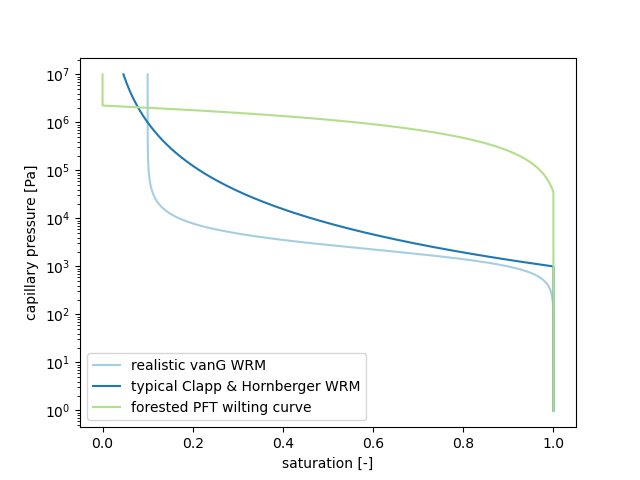

### Transpiration Downregulation: Plant + Soil Limitations

Alternatively, Painter & Coon derived a model that leverages a competing rates approach.  This computes a "plant water potential" at the plant collar, and downregulates based on that plant water potential.  It simultaneously computes the flux of water from soil to root by a potential difference between the soil water potential and the plant water potential, multiplied by a factor that includes the soil relative permeability.  This also includes a plant-functional-type parameter, the water potential at fully closed stomata (the wilting point).  It brings in both soil and plant properties.


### Rooting distribution

In both cases, the rooting distribution function is needed to distribute downregulated transpiration across the vertical column.  This is also taken from CLM 4.5 technical note, and is plant-functional-type specific.

In [ ]:
# Example: plot of run-trans-no_downreg, run-trans-downreg
fig, axs = plt.subplots(1,2, figsize=(8,4)) 

# load and plot the no-downregulation case
plotColumn('run-trans-no_downreg', axs[0], lower_bound=8)

# load and plot the downregulated case
plotColumn('run-trans-downreg', axs[1], lower_bound=8)

# plot residual saturation
axs[0].plot([0.1, 0.1], [0, 10], '--', color='grey')
axs[1].plot([0.1, 0.1], [0, 10], '--', color='grey')

plt.tight_layout()
plt.show()

In [ ]:
# Example: run-evap-no_downreg, run-evap-downreg
fig, axs = plt.subplots(2,2, figsize=(8,8)) 

# load and plot the no-downregulation case
plotWaterBalance('run-trans-no_downreg', axs[:,0])

# load and plot the downregulated case
plotWaterBalance('run-trans-downreg', axs[:,1])

# set same limits on flux plots
axs[0,0].set_ylim(-.2, .2)
axs[0,1].set_ylim(-.2, .2)
axs[0,0].set_xlim(0,30)
axs[0,1].set_xlim(0,30)

axs[1,0].set_ylim(-0.001, 0.006)
axs[1,1].set_ylim(-0.001, 0.006)
axs[1,0].set_xlim(0,30)
axs[1,1].set_xlim(0,30)

plt.tight_layout()
plt.show()

In [ ]:
# Example: plot of run-trans-no_downreg, run-trans-downreg
fig, axs = plt.subplots(1,2, figsize=(8,4)) 

# load and plot the no-downregulation case
plotColumn('run-trans-no_downreg', axs[0], lower_bound=8, variable='transpiration')
axs[0].set_xlim(0, 0.01)

# load and plot the downregulated case
plotColumn('run-trans-downreg', axs[1], lower_bound=8, variable='transpiration')
axs[1].set_xlim(0, 0.01)

plt.tight_layout()
plt.show()

## Potential Evapotranspiration


### Prescribed P - ET

Often precipitation and evapotranspiration are known from either a preexisting land model run, remotely sensed or point data (e.g. eddy flux towers and weather stations) or other approaches.  In this case, downregulation is recommended in case the data is inconsistent with the soil moisture.


### Basic Priestley-Taylor

Many empirical models of evapotranspiration have been defined.  One of the most commonly used is the Priestley-Taylor model, which is itself a variant of the Penman-Monteith equation.  Our implementation follows that of USGS's PRMS model.



Required data:

* net radiation, typically either incoming shortwave or incoming shortwave + incoming longwave - outgoing longwave
* surface temperature (for outgoing longwave and ground conduction) -- typically "yesterday's air temperature"
* Preistley-Taylor coefficient $\alpha$ -- land cover type specific



### Priestley-Taylor on Four Buckets

This approach leverages the Priestley-Taylor equation to compute potential evapotranspiration, but does four separate calculations, one each for:

* canopy leaf water (canopy evaporation)
* canopy transpiration
* bare soil evaporation
* snow sublimation

<div>
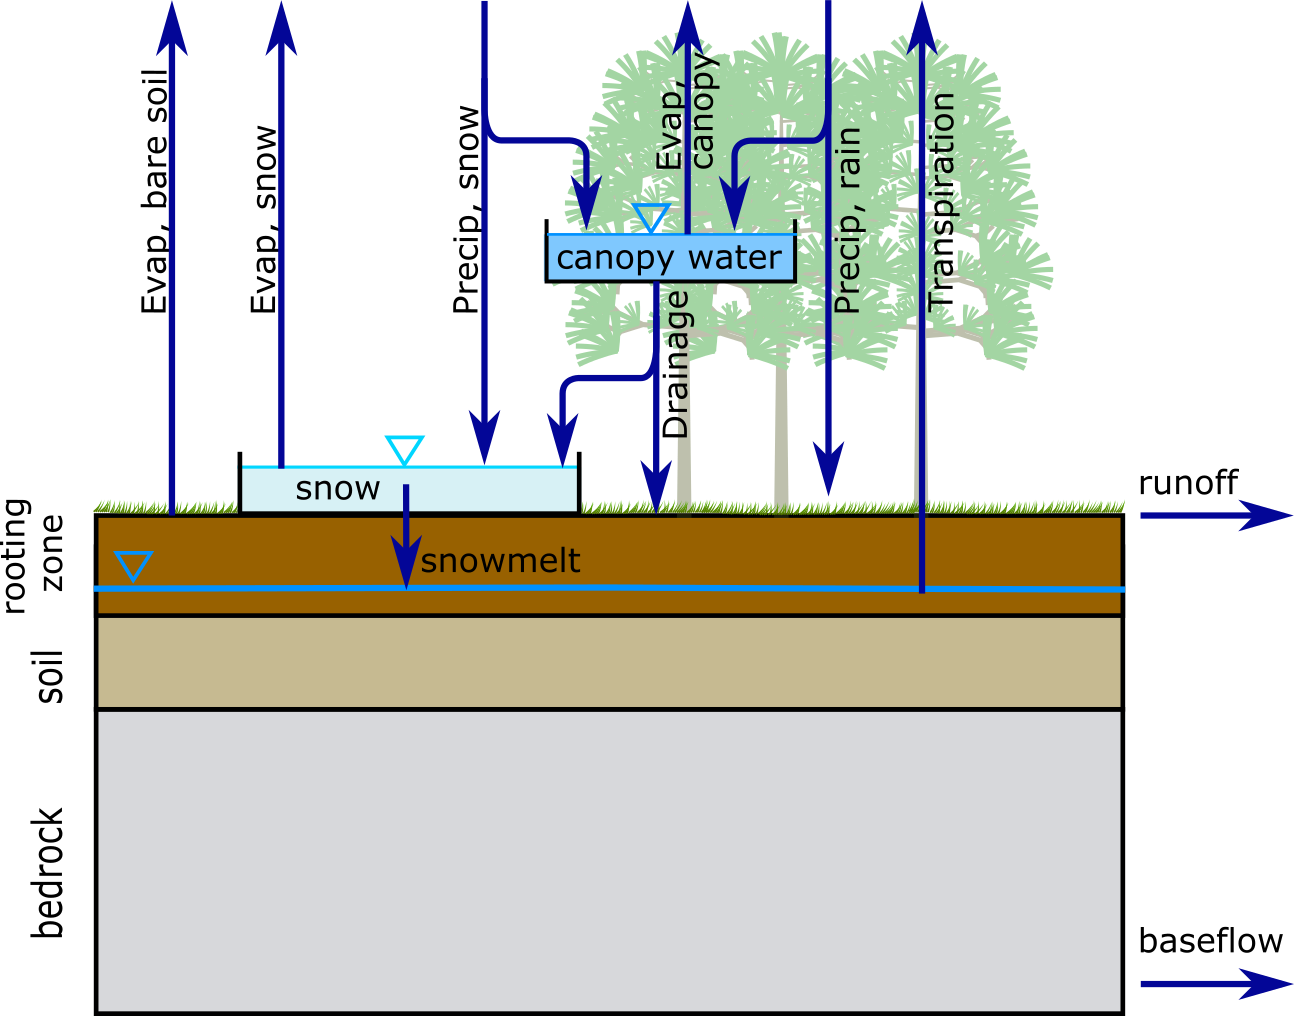
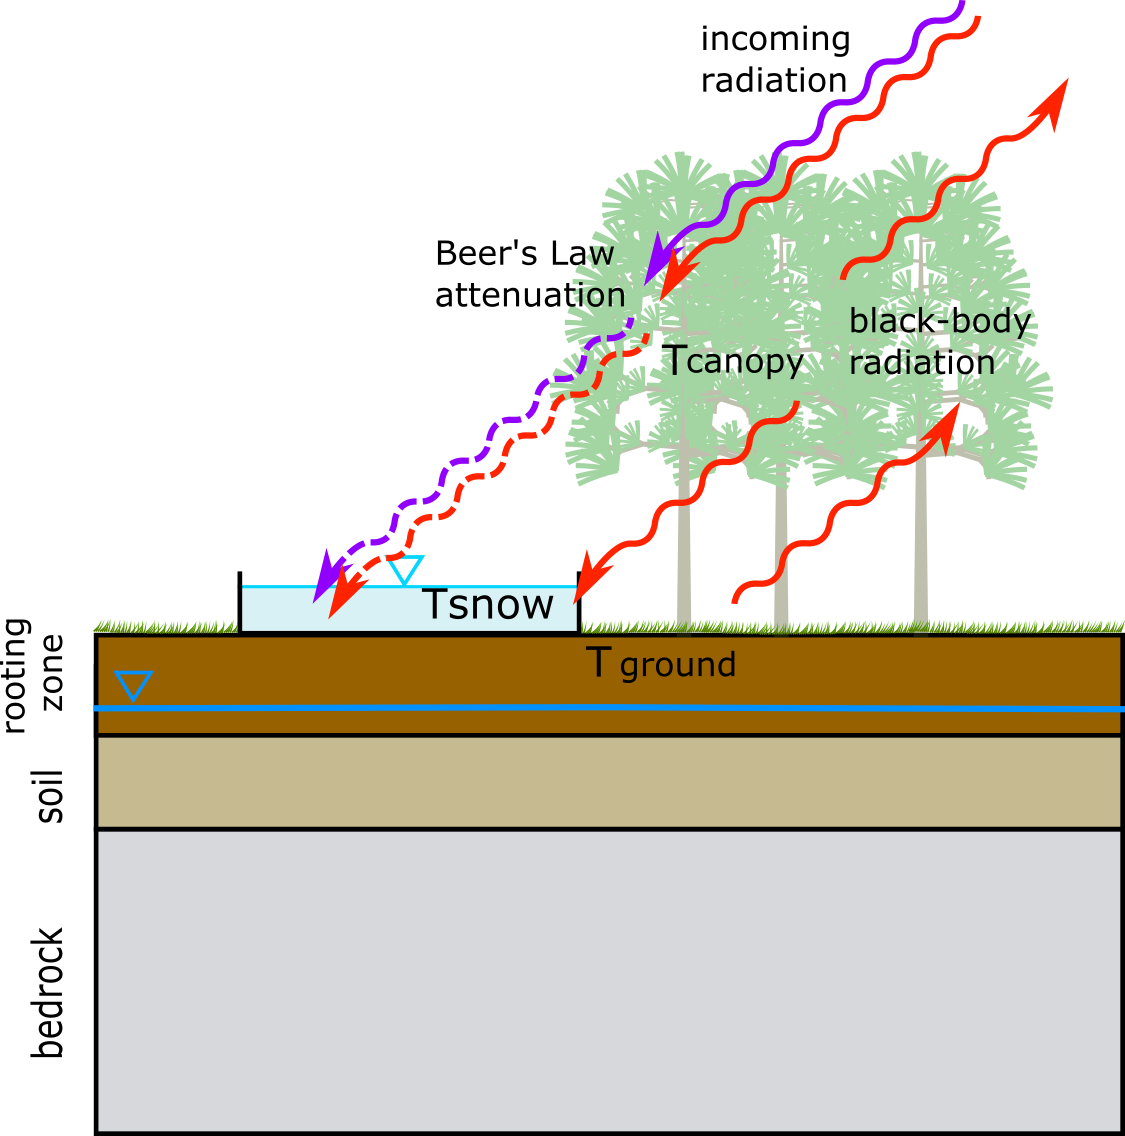
</div>


Required data/parameters:

* Leaf Area Index (interception, shading/radiation balance)
* incoming shortwave & incoming longwave radiation
* plant properties (specific leaf area, Beer's attenuation coefficient)
* surface temperature -- typically "yesterday's air temperature"
* snow - air relative temperature -- snow is assumed to begin melting once the air temperature reaches a certain value (above 0 C)


In [ ]:
# Example: run-priestley_taylor
fig, axs = plt.subplots(2,1, figsize=(8,8)) 

# load and plot the no-downregulation case
plotWaterBalance('run-priestley_taylor', axs)

plt.tight_layout()
plt.show()

### Full & Simple Energy Balances

When an energy equation is solved, we dynamically compute the soil temperature.  Ground conduction is no longer empirical, and surface skin temperature is solved by assuming a surface energy balance.

Latent and Sensible heat exchange are modeled given wind speed, soil roughness, and other parameters.

* Full energy balances solves a full energy equation including freeze-thaw.
* Simple energy balance solves a simplified energy equation limited to energy conduction and no phase change.
